# Tutorial Four: Multicollinearity

## 实验前的准备

本次实验我们载入一些Python的安装包，如下：

In [1]:
from sklearn.datasets import load_diabetes

import os

import pandas as pd
import numpy as np
import random
import seaborn as sns

import scipy.stats as stats
import matplotlib.pyplot as plt
import math


from itertools import combinations
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model  # 进行岭回归分析
from sklearn import preprocessing


设置数据目录，如下：

In [4]:
os.chdir("/Users/lyuni/ECNU_DaSE/Courses/Stat_ML/Experiment/Data")

在本次实验中，所使用的数据集是

In [5]:
Data = pd.read_csv("Data_4.csv")
print(Data.head())

   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    315    81      7    24   38     39     14    3449    835      69    321   
1    479   130     18    66   72     76      3    1624    457      63    224   
2    496   141     20    65   78     37     11    5628   1575     225    828   
3    321    87     10    39   42     30      2     396    101      12     48   
4    594   169      4    74   51     35     11    4408   1133      19    501   

   CRBI  CWalks  PutOuts  Assists  Errors  Salary  
0   414     375      632       43      10   475.0  
1   266     263      880       82      14   480.0  
2   838     354      200       11       3   500.0  
3    46      33      805       40       4    91.5  
4   336     194      282      421      25   750.0  


我们可以了解这个数据集的样本量、特征维度等特征，如下：

In [6]:
p = Data.shape[1]-1
n = Data.shape[0]

print("The number of features is",p)
print("The sample size is",n)

The number of features is 16
The sample size is 263


## 背景

本次数据来自于1986年至1987年间美国职业棒球大联盟。这个数据记录了263名大联盟的选手所采集的收入数据及其历史棒球运动的表现。

## 数据
在本次数据中，共有17个变量（1个响应变量与16个自变量），具体如下表所示：

<table width = c(100,800,700), center = True>
    <tr>
        <td> 变量名                  </td>
        <td> 英文变量含义                 </td>
        <td> 中文变量含义                 </td>
    </tr>
    <tr>
        <td> AtBat                          </td>
        <td> Number of times at bat in 1986 </td>
        <td> 1986年间轮到击球的次数            </td>
    </tr>
    <tr>
        <td> Hits                         </td>
        <td> Number of hits in 1986       </td>
        <td> 1986年间击中球的次数           </td>
    </tr>
    <tr>
        <td> HmRun                         </td>
        <td> Number of home runs in 1986   </td>
        <td> 1986年间全垒打的次数             </td>
    </tr>
     <tr>
        <td> Runs                              </td>
        <td> Number of runs in 1986            </td>
        <td> 1986年间得分的次数                   </td>
    </tr>
    <tr>
        <td> RBI                               </td>
        <td> Number of runs batted in in 1986  </td>
        <td> 1986年间打者打点的次数                   </td>
    </tr>
    <tr>
        <td> Walks                               </td>
        <td> Number of walks in 1986  </td>
        <td> 1986年间打击手被保送的次数                   </td>
    </tr>
    <tr>
        <td> Years                               </td>
        <td> Number of years in the major leagues  </td>
        <td> 在大联盟的年限                  </td>
    </tr>
     <tr>
        <td> CAtBat                               </td>
        <td> Number of times at bat during his career  </td>
        <td> 在其棒球职业生涯中轮到击球的次数                 </td>
    </tr>
    <tr>
        <td> CHits                              </td>
        <td> Number of hits during his career  </td>
        <td> 在其棒球职业生涯中击中球的次数                 </td>
    </tr>
    <tr>
        <td> CHmRun                              </td>
        <td> Number of home runs during his career  </td>
        <td> 在其棒球职业生涯中全垒打的次数                 </td>
    </tr>
    <tr>
        <td> CRuns                              </td>
        <td> Number of runs during his career  </td>
        <td> 在其棒球职业生涯中得分的次数                 </td>
    </tr>
    <tr>
        <td> CRBI                              </td>
        <td> Number of runs batted in during his career  </td>
        <td> 在其棒球职业生涯中打者打点的次数                 </td>
    </tr>
    <tr>
        <td> CWalks                              </td>
        <td> Number of walks during his career  </td>
        <td> 在其棒球职业生涯中打击手被保送的次数                 </td>
    </tr>
    <tr>
        <td> PutOuts                              </td>
        <td> Number of put outs in 1986  </td>
        <td> 在1986年间接杀的次数                 </td>
    </tr>
    <tr>
        <td> Assists                             </td>
        <td> Number of assists in 1986  </td>
        <td> 在1986年间助杀的次数                 </td>
    </tr>
    <tr>
        <td> Errors                            </td>
        <td> Number of errors in 1986          </td>
        <td> 在1986年间失误的次数                 </td>
    </tr>
    <tr>
        <td> Salary                            </td>
        <td> 1987 annual salary on opening day in thousands of dollars          </td>
        <td> 在1987年开业时年薪（单位：千美元）         </td>
    </tr>
</table>

## 任务

本次实验中，我们需要解决以下问题：

1. 这些特征是否存在多重共线性？如何判断？
2. 如何利用岭回归改进模型？
3. 岭回归估计是否比最小二乘估计更优？

## 解决方案

在正式分析这个问题之前，我们介绍一下数据分析的基础步骤。
第一步：数据采集（问卷、爬虫、系统采集等方式）与数据清洗；
第二步：数据预处理（缺失、异常等，划分训练集和测试（验证）集）；
第三步：数据的探索性分析（计算简单的统计量、绘制基础图表）；
第四步：构建模型（针对所提出的问题，利用模型来解决）；
第五步：模型诊断（考虑所提出是否符合数据）；
第六步：得出结论（根据数据分析结果给出合理且科学的决策）。

在本次实验中，我们简化了前三步骤。在数据预处理中，需要划分训练集和测试集，常见的方法有：留出法（Hold-out）和$K$折交叉验证法（K-fold Cross Validation）。我们这里介绍留出法，具体如下：

在留出法中，需要划分两个数据集——训练集和测试集。

第一，需要确定两个数据集的样本量。通常按一定比例，如8:2。

In [13]:
n_train = 210 # 80% instances used for training
n_test = n-n_train

第二，在所有样本中随机选取。这里我们固定随机种子，优势是：这样的划分是相对确定性的，有利于在编程过程中反复验证结果是否正确。

In [14]:
seed = 1
random.seed(seed)
index = range(0,n)
index_selected = random.sample(index,n_train)
index_selected.sort()

第三，我们根据所确定的索引将数据划分为两个数据集。

In [15]:
Data_train = Data.loc[index_selected]
Data_test = Data.drop(index = index_selected)

在数据预处理中，除了划分训练集和测试集之外，我们还需要根据模型重新构建数据类型。比如在回归模型中，将响应变量和特征拆分为两个部分，即

In [16]:
## Pre-processing
X_train = Data_train.drop(columns = ['Salary'],axis = 1)
Y_train = Data_train.Salary
X_test = Data_test.drop(columns = ["Salary"],axis=1)
Y_test = Data_test.Salary

在分析多重共线性时，我们需要将数据进行**标准化**。

在数据$\{(y_i,\mathbf{x}_i):i=1,2,\cdots,n\}$，其中，$\mathbf{x}_i = (x_{i1},x_{i2},\cdots,x_{ip})'$，传统的标准化指的是
$$
x_{ij}^{\ast} = \frac{x_{ij}-\bar{x}_j}{\sqrt{\frac{1}{n-1} \sum_{i=1}^n (x_{ij} - \bar{x}_j)^2}}
$$
注：这里分母中的方差通常用样本方差（即前面的系数为$(n-1)^{-1}$），也有使用总体方差（即前面的系数为$(n)^{-1}$）。在$n$很大时，分母上方差无明显差异。传统的标准化指的是：使得均值为0、方差为1。

而在本实验中，我们所定义的**标准化**为
$$
x_{ij}^{\ast} = \frac{x_{ij}-\bar{x}_j}{\sqrt{\sum_{i=1}^n (x_{ij} - \bar{x}_j)^2}}
$$
这里与传统的标准化相差一个常数。

In [17]:
X_train_standardized = preprocessing.scale(X_train, with_mean = True, with_std=True)/np.sqrt(n_train)
Y_train_centered = preprocessing.scale(Y_train, with_mean = True, with_std=False)
Y_train_mean = np.average(Y_train)
X_test_standardized = preprocessing.scale(X_test, with_mean = True, with_std=True)/np.sqrt(n_test)

这里有一个问题值得注意：关于测试数据的标准化，对于测试数据而言，其标准化的方式仅仅只能利用可以观测到的数据，不能使用需要**未知**信息。在回归问题中，这样进行标准化是可行的，因为在测试集中特征是可观测到的，才能通过这些特征来进行预测，所以这种方法是可行的。如果是在时间序列等场景，一定需要注意，不要利用未来的信息做数据预处理，这样是不正确的。

### Task 1: 多重共线性诊断

我们首先跑一个线性回归模型，对结果进行分析。

In [18]:
X_train_withintercept = sm.add_constant(X_train)
model = sm.OLS(Y_train,X_train_withintercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     17.42
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.88e-29
Time:                        02:09:40   Log-Likelihood:                -1483.7
No. Observations:                 210   AIC:                             3001.
Df Residuals:                     193   BIC:                             3058.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        184.2230     91.411      2.015      0.045       3.930     364.515
AtBat         -2.5127      0.673     -3.732      0.000      -3.841      -1.185
Hits          10.9852      2.545      4.317      0.000       5.967      16.004
HmRun         -4.3432      6.662     -0.652      0.515     -17.483       8.796
Runs          -5.0320      3.085     -1.631      0.104     -11.116       1.052
RBI           -1.4118      2.666     -0.530      0.597      -6.670       3.846
Walks          7.8608      1.929      4.075      0.000       4.056      11.665
Years        -10.2313     13.991     -0.731      0.465     -37.826      17.364
CAtBat        -0.0192      0.141     -0.136      0.892      -0.298       0.259
CHits         -0.1728      0.688     -0.251      0.802      -1.530       1.184
CHmRun         3.0831      1.862      1.656      0.099      -0.589       6.755
CRuns          1.1291      0.781      1.445      0.150      -0.412       2.670
CRBI           0.1071      0.766      0.140      0.889      -1.404       1.618
CWalks        -0.7261      0.349     -2.081      0.039      -1.414      -0.038
PutOuts        0.1723      0.082      2.098      0.037       0.010       0.334
Assists        0.4055      0.225      1.803      0.073      -0.038       0.849
Errors        -4.4775      4.427     -1.011      0.313     -13.208       4.253
==============================================================================
Omnibus:                      113.886   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              966.375
Skew:                           1.909   Prob(JB):                    1.43e-210
Kurtosis:                      12.791   Cond. No.                     1.67e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

从两个方面可以发现：
1. 参数估计的$t$检验中，大部分都是不显著的。虽然参数估计的取值很大，但检验结果却不显著。
2. 在线性回归模型中，输出了第二句话：The condition number is large, 1.67e+04. This might indicate that there are strong multicollinearity or other numerical problems. 这表明可能存在多重共线性或其他问题。

接下来，我们一般在数据探索性分析中能够初步判断数据是否出现多重贡献性，即关注特征之间是否存在高相关性。

<AxesSubplot:>

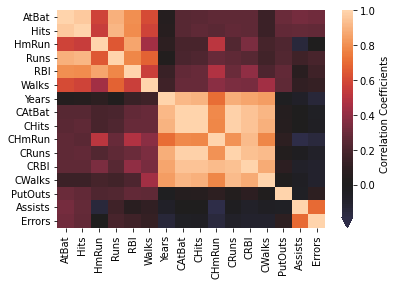

In [19]:
pcorr = X_train.corr(method = 'pearson')
tick_ = (np.arange(0,13,2)-2)/10
dict_ = {"orientation":'vertical',
         'label':'Correlation Coefficients',
         "drawedges":False,
         "ticklocation":"top",
         "extend":"min",
        "filled":True,
         "alpha":0.8,
         "cmap":"cmap",
         "ticks":tick_}
sns.heatmap(pcorr,cbar_kws= dict_,center=0)

仅仅考察特征之间的相关性无法准确判断数据是否出现多重共线性的。一般而言，我们有两种数值上的方法来诊断数据是否存在多重共线性。

#### 方差扩大因子法（VIF）

假定特征数据已经经过标准化，现数据有
$$
X = \begin{pmatrix}
x_{11} & x_{12} & \cdots & x_{1p}\\
x_{21} & x_{22} & \cdots & x_{2p}\\
\vdots & \vdots &  & \vdots \\
x_{n1} & x_{n2} & \cdots & x_{np}\\
\end{pmatrix}
$$

方差扩大因子指的是$(X'X)^{-1}$的对角线元素。

In [27]:
# Method One
C = np.linalg.inv(np.dot(X_train_standardized.T,X_train_standardized))
VIF_1 = np.diag(C)
print("The VIF's are", np.round(VIF_1,2))

# Method Two
VIF_2 = [variance_inflation_factor(X_train_standardized[:,0:p], i) for i in range(p)]
print("The VIF's are", np.round(VIF_2,2))

# Method Three
X_1 = X_train_standardized[:,0]
X_others = X_train_standardized[:,1:p]
model_vif = sm.OLS(X_1,X_others).fit()
X_1_VIF = 1/(1-model_vif.rsquared)
print("The VIF's are", np.round(X_1_VIF,2))


The VIF's are [ 22.91  30.81   8.11  14.14  11.67   3.92   9.59 242.45 474.68  45.5
 154.87 133.93  17.44   1.28   2.65   2.13]
The VIF's are [ 22.91  30.81   8.11  14.14  11.67   3.92   9.59 242.45 474.68  45.5
 154.87 133.93  17.44   1.28   2.65   2.13]
The VIF's are 22.91


注意到，方法一中给出的结果是根据定义给出的。但是，问题是：为什么方差扩大因子能够度量特征存在多重共线性？

举例来说，以$x_j$作为响应变量，其他特征$x_1,x_2,\cdots,x_{j-1},x_{j+1},\cdots,x_{p}$作为自变量，构建线性回归模型即
$$
x_j = \alpha_0 + \alpha_1 x_1 \alpha_2 x_2 + \cdots \alpha_{j-1}x_{j-1} + \alpha_{j+1}x_{j+1} + \cdots + \alpha_p x_p +\epsilon
$$

如果这个特征能够被其他特征近似看作其他特征的线性组合，那么我们称这个现象为**多重共线性**。基于这个想法，如果上述回归模型的决定系数$R^2$很接近于1，那么这个特征很有可能看作其他特征的线性组合。因此，多重共线性VIF还有一种计算方法，即
$$
\text{VIF}_j = \frac{1}{1-R_j^2} 
$$

方差扩大因子的评价方式：如果方差扩大因子越大，那么可以认为多重共线性的线性约严重。通常临界值取5、10、100等，可以根据样本量来确定。

In [28]:
vif_cv = 5 # The criterion value of VIF

因为我们发现通常在构建一个ols模型之后，我们需要提取一些其重要的数值、向量或矩阵，这里我们梳理一下常用的参数。

In [29]:
## 补充内容：
#model_vif.summary()
## 建模类
#model_vif.params # 回归系数(向量，p)
#model_vif.bse # 回归系数的标准误
#model_vif.tvalues # 回归系数的t统计量（向量，p）
#model_vif.pvalues # 回归系数的t检验对应的p值（向量，p）
#model_vif.fittedvalues # 回归模型的拟合值（向量，n）
#model_vif.resid # 回归模型的残差（向量，n）

## 评价类
#model_vif.fvalue # 回归模型的F检验统计量
#model_vif.f_pvalue # 回归模型的F检验对应的p值
#model_vif.rsquared # 回归模型的决定系数R2
#model_vif.rsquared_adj # 回归模型修正后的决定系数 Adj. R2
#model_vif.ess # 回归平方和
#model_vif.ssr # 残差平方和
#model_vif.aic # AIC
#model_vif.bic # BIC


#### 特征值法

在多重共线性的根本问题中，可以发现$X'X$的行列式接近于零，但并不为零。由于$X'X$是实对称矩阵，根据线性代数的知识，$X'X$是可以进行特征值分解的，即
$$
(X'X)\mathbf{v}_i = \lambda_i\mathbf{v}_i, i=1,2,\cdots,p.
$$
其中，$\lambda_1\geq \lambda_2 \geq \cdots \geq \lambda_p$。因此，
$$
|X'X| = \prod_{i=1}^p \lambda_i
$$

基于此，我们定义其条件数来进行判断数据是否具有多重共线性，即
$$
\kappa_i = \sqrt{\lambda_1/\lambda_i}, i=1,2,\cdots,p.
$$
如果 $\kappa_p$ 越大，那么可以认为数据有存在多重共线性的可能性。条件数的判断临界值为10、100及1000等。

In [30]:
## Method One：
R = np.dot(X_train_standardized.T,X_train_standardized)
W, V = np.linalg.eig(R)
W = -1* np.sort(-1*W)
W_diag = np.diag(W)
V = V.T
print("The eigen values are", np.round(W,4))

Condition_Number = np.sqrt(np.max(W)/np.min(W))
print("The condition number is",np.round(Condition_Number,4))

## Method Two：
model_ols = sm.OLS(Y_train_centered,X_train_standardized).fit()
print("The condition number is",round(model_ols.condition_number,4))

The eigen values are [7.2985e+00 3.9851e+00 1.7352e+00 9.1210e-01 6.8070e-01 5.5120e-01
 2.6490e-01 1.8050e-01 1.2800e-01 1.0050e-01 6.0000e-02 5.3300e-02
 2.8200e-02 1.6100e-02 4.4000e-03 1.3000e-03]
The condition number is 75.7146
The condition number is 75.7146


### Task 2: 岭回归

这里我们介绍在线性回归模型中增加了惩罚项。在岭回归中，我们需要得到解的结构是
$$
\hat{\mathbf{\beta}} = (X'X+kI)^{-1}X'\mathbf{y}
$$
是以下最优化问题
$$
\min (\mathbf{y} - X\mathbf{\beta})'(\mathbf{y} - X\mathbf{\beta}) \quad \text{s.t.}  \quad \mathbf{\beta}'\mathbf{\beta}\leq s
$$
的解。

在Python中，我们可以用不同的包来解决这个问题。我们仍采用statsmodels.api这个包来拟合岭回归模型。在这个包中，不是单一地处理岭回归估计问题，而是处理Elastic Net的问题。在Elastic Net中，最优化问题是
$$
0.5* RSS/n +alpha *((1-L1_wt)*|params|_2^2/2 + L1_wt * |params|_1)
$$
其中，
- RSS：原本的偏差平方和；
- n：样本量；
- $|\cdot|_1,|\cdot|_2$：$L_1$和$L_2$范数。

【课堂问题】这里$\alpha$与$k$之间的关系是什么？

In [32]:
## Ridge Regression
alpha  = 0.1 # A hyperparameter in Ridge Regression (equivalently but not equally, k in slides)
model_rr = sm.OLS(Y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha)
print("The parameters in the ridge regression are ",np.round(model_rr.params,2))

k = alpha * n_train # The relation between alpha and k
print("The parameters in the ridge regression are ", np.around(np.linalg.inv(X_train_standardized.T @ X_train_standardized + k * np.eye(p)) @ X_train_standardized.T @ Y_train_centered,2))




The parameters in the ridge regression are  [ 84.07  97.4   62.58  87.16  87.79 113.32 100.7  128.48 132.56 146.93
 137.78 145.26 124.65  51.17   7.34  -7.15]
The parameters in the ridge regression are  [ 84.07  97.4   62.58  87.16  87.79 113.32 100.7  128.48 132.56 146.93
 137.78 145.26 124.65  51.17   7.34  -7.15]


如何选择最优的岭参数（超参数）？这里我们介绍一种方法，通过关注方差扩大因子是否减小到临界值的范围内，从而来确定我们的模型。

In [33]:
alpha_num = 100
alpha_vec = np.array(list(range(0,alpha_num)))/alpha_num/1000
RR_coef = []
RR_vif = []

for alpha in alpha_vec:
    rr_model = sm.OLS(Y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha)
    rr_coef = rr_model.params
    RR_coef.append(rr_coef)
    

这里我们可以绘制岭迹图，如下图。

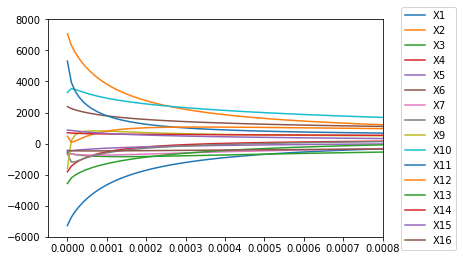

In [34]:
for i in range(p):
    plt.plot(alpha_vec, np.array(RR_coef)[:,i],label = "X%d"%(i+1))

plt.axis([-0.00005,0.0008,-6000,8000])    
plt.legend(loc="right",bbox_to_anchor=(1.25,0.5),borderaxespad=1)


通过上图，我们可以发现：
1. 随着k不断的增加，岭回归估计越来越接近于零；
2. 随着k不断增加，岭回归估计的符号会变化；
3. 从岭迹图中，我们选择趋于平稳的点。

这里我们通过计算岭估计对应的方差扩大因子。在岭回归中，方差扩大因子为
$$
C(k) = (X'X + kI)^{-1} X'X (X'X + kI)^{-1} .
$$
直到方差扩大因子不大于临界值。

In [35]:
C_k = []
for alpha in alpha_vec:
    k = alpha * n_train
    c_k = np.linalg.inv(X_train_standardized.T @ X_train_standardized + k * np.eye(p)) @ X_train_standardized.T @ X_train_standardized @ np.linalg.inv(X_train_standardized.T @ X_train_standardized + k * np.eye(p))
    C_k.append(np.mean(np.diag(c_k)))

alpha_best = alpha_vec[np.min(np.where(np.array(C_k) < vif_cv))]
print("The chosen value of alpha is", alpha_best)

The chosen value of alpha is 0.0001


### Task 3: 比较岭回归估计与最小二乘估计

这里我们采用测试集的RMSE来比较两种估计方法的优劣。

In [331]:
model_rr_best = sm.OLS(Y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha_best)
model_rr_best_coef = model_rr_best.params

Y_pred_rr = Y_train_mean + X_test_standardized @ model_rr_best_coef
rr_rmse = np.sqrt(np.mean((Y_pred_rr-Y_test)**2))

model_ols_coef = model_ols.params 
Y_pred_ols = Y_train_mean + X_test_standardized @ model_ols_coef
ols_rmse = np.sqrt(np.mean((Y_pred_ols-Y_test)**2))

print("The RMSE in the ridge regression is", round(rr_rmse,4))
print("The RMSE in the ordinary regression is", round(ols_rmse,4))



The RMSE in the ridge regression is 566.0067
The RMSE in the ordinary regression is 591.1203
